# Sheet 3 - Simulation Exercise (Probit Model - Gibbs and M-H)

In [2]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, GraphRecipes, KernelDensity
using GaussianMixtures
using LaTeXStrings
pyplot()

┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/GraphRecipes/7oEYB.ji for GraphRecipes [bd48cda9-67a9-57be-86fa-5b3c104eda73]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/GaussianMixtures/1kPVN.ji for GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


Plots.PyPlotBackend()

In the probit model we have the similar situation that we have for the linear regression,
hence:
$$
Y = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n
$$
But $Y = 0$ or $1$, so we have to transform the linear equation to fall between 0 and 1.
To do that, we use the cdf for the normal distribution.
$$
Y = \phi(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)
$$
Note that the cdf will guarantee a value between 0 and 1.

1. Generate a synthetic dataset Y from the probit model for an arbitrary value of β and a matrix X.

In [3]:
n    = 50
beta = [1 -1]
X    = [rand(Normal(0,1),n,1) rand(Normal(0,2),n,1)]

# cdf.(Normal(0,1),X)
# X' * beta
Y = (cdf.(Normal(0,1),X*beta') .>= 0.5).*1;
C = countmap(Y[:])

Dict{Int64,Int64} with 2 entries:
  0 => 24
  1 => 26

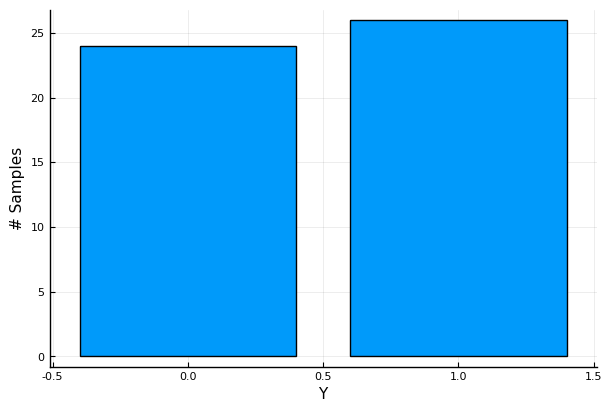

In [14]:
p = Plots.bar(C,legend = false,xlabel = "Y",
    ylabel="# Samples")
Plots.savefig(p,"./images/Ex6_1.png")

2. Introduce the prior distribution on β:
$$\pi(\beta) = N (0, B)$$
for a p × p covariance matrix B. Write a function taking a vector β as argument and returning the log
posterior density function evaluated at β.

Note that
$$
p(\beta \mid Y) \propto \pi(\beta)\prod^n_{i=1}\phi(X_i^T\beta)^{y_i}(1-\phi X_i^T \beta)^{1-y_i}
$$


In [15]:
B = [1.0 0;
     0 1.0]

function LogPosterior(beta)
    post = Y'*logcdf.(Normal(0,1),X*beta') + (1 .- Y)'* logcdf.(Normal(0,1),-X*beta').+ logpdf(MvNormal(B),beta')
    return post[1]
    
end
beta1 = 1.0
beta2 = 5.0
LogPosterior(beta)

-12.33726392762875

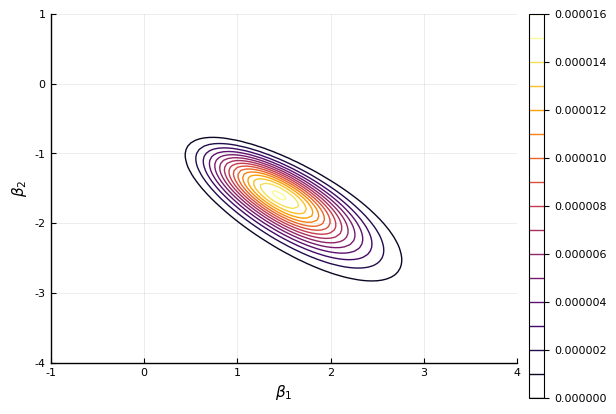

In [19]:
y = -4:0.05:1
x = -1:0.05:4
gridx = repeat(reshape(x, 1, :), length(y), 1)
gridy = repeat(y, 1, length(x))
f(x,y)= exp(LogPosterior([x y]))
Z = map(f, gridx, gridy)
p1 = contour(x,y, f, fill=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")

savefig(p1, "./images/Ex6_2.png")

3. Run Metropolis-Hastings

Sample $X^*$ from $q(\cdot \mid X_{t-1})$, where $q$ is a random walk centered at $X_{t-1}$. We then accept the new step
with probability $\alpha = min\{1, \frac{\pi(X^*)}{\pi(X_{t-1})} \}$

In [20]:
# Sample X
burnin = 1_000
steps = 30_000
C = zeros(steps,length(beta))
Xprevious   = [0;0]

for i=1:steps
    Xnew        = Xprevious + randn(2)
    alpha = minimum([1,exp(LogPosterior(Xnew') - LogPosterior(Xprevious'))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
end

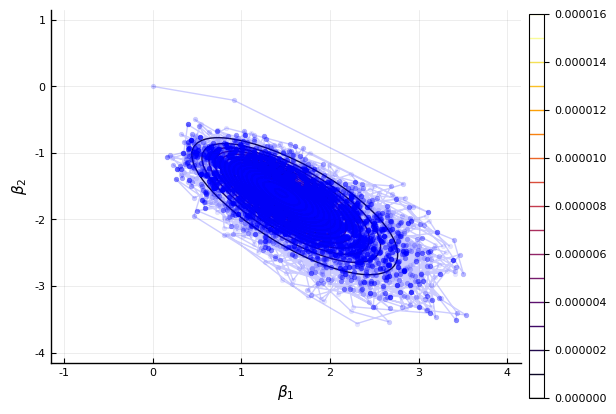

In [22]:
contour(x,y, f, fill=false)
p = plot!(C[:,1],C[:,2],marker=:o,color=:blue,
    alpha=0.2, markeralpha = 0.1,
    markerstrokewidth=0,legend=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")
savefig(p, "./images/Ex6_3.png")
# histogram2d!(C[:,1],C[:,2],alpha=0.2)

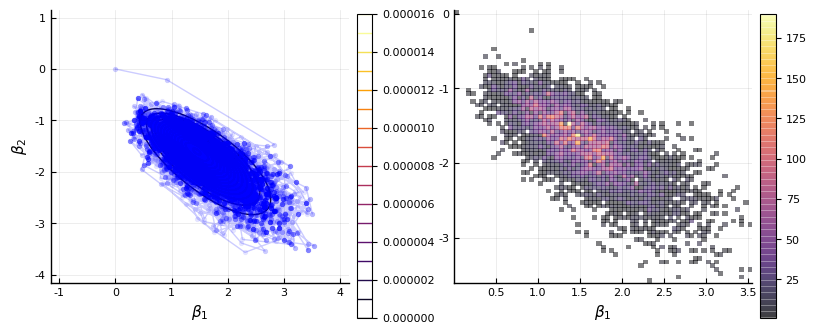

In [32]:
# Uncomment this to plot the contours instead of the histogram
# density = kde(C[burnin:end,:],boundary=((0.,3),(-4,0)),npoints=((100,100))) #npoints = ((100,100))
# plot(density)

contour(x,y, f, fill=false)
p = plot!(C[:,1],C[:,2],marker=:o,color=:blue,
    alpha=0.2, markeralpha = 0.1,
    markerstrokewidth=0,legend=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")

h = histogram2d(C[:,1],C[:,2],alpha=0.5,nbins=100,
    xlabel=L"\beta_1")
pp = plot(p,h, layout=2, size=(1000*0.8,400*0.8))
savefig(pp, "./images/Ex6_3.png")

4. For all i = 1, . . . , n, introduce the random variable $Z_i$ distributed as $N (X^T_i \beta, 1)$. Compare the law of
$\mathbb 1_{Z_i≥0}$ with the law of $Y_i$. 

First, note that $Z_i > 0$, when $Y_i =1$, and $Z_i \leq 0$ otherwise.

In [35]:
# TruncatedNormal()
TruncatedNormal((X*beta')[1],1,-Inf,0) # If Y_i = 0
TruncatedNormal((X*beta')[1],1,0,Inf) # If Y_i = 1

Truncated(Normal{Float64}(μ=2.241876578527898, σ=1.0), range=(0.0, Inf))

In [36]:
rand(TruncatedNormal((X[1,:]'*beta')[1],1,0,Inf))
rand(TruncatedNormal((X[1,:]'*beta')[1],1,-Inf,0)) # If Y_i = 0

-0.1622790009672097

5. Use Z to design a Gibbs sampler, alternatively sampling from β given Z, Y and from Z given β, Y
$$p(\beta \mid Z, Y) = N(\tilde \mu, \tilde \Sigma)$$
Where, $\tilde \Sigma^{-1} = \Sigma^{-1} + \sum^m_{i=1}x_ix_i^T$,
$\tilde \mu = \tilde \Sigma(\Sigma^{-1}\mu + \sum^n_{i=1}x_iz_i)$

In [40]:
function Sample_Z_Posterior(Y,X,beta)
    Z = zeros(n)
    for i= 1:n
        if Y[i]==1
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,0,Inf)) # If Y_i = 1
        else
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,-Inf,0)) # If Y_i = 0
        end
    end 
    return Z
end

function Sample_beta_Posterior(Z,X)
    B_tilde  = inv(inv(B) + X' * X)
    mu_tilde = B_tilde * (X'*Z)
    return rand(MvNormal(mu_tilde, B_tilde))'
end
Z = Sample_Z_Posterior(Y,X,beta)
Sample_beta_Posterior(Z,X)

1×2 Adjoint{Float64,Array{Float64,1}}:
 1.02704  -0.90511

In [42]:
steps  = 10_000
GibbsChain = zeros(steps,length(beta))
# B,beta,X,Y
beta_current = beta
for i=1:steps
    Z = Sample_Z_Posterior(Y,X,beta_current)
    beta_current = Sample_beta_Posterior(Z, X)
    GibbsChain[i,:] = beta_current
end

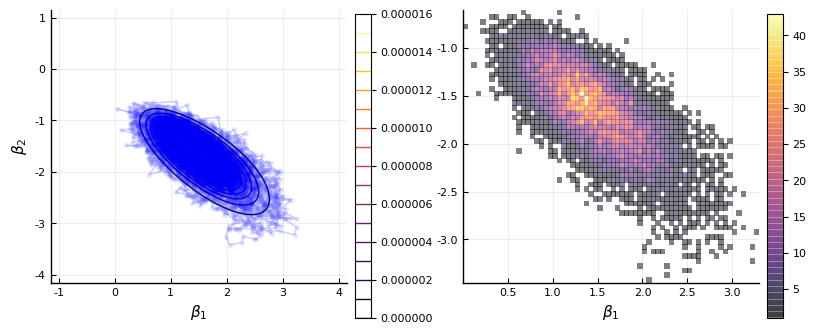

In [44]:
contour(x,y, f, fill=false)
p = plot!(GibbsChain[:,1],GibbsChain[:,2],
    marker=:o,color=:blue,
    alpha=0.2, markeralpha = 0.1,
    markerstrokewidth=0,legend=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")
h = histogram2d(GibbsChain[:,1],GibbsChain[:,2],
    alpha=0.5,nbins=100,xlabel = L"\beta_1")

pp = plot(p,h, layout=2, size=(1000*0.8,400*0.8))
savefig(pp, "./images/Ex6_4.png")

In [33]:
# Uncomment this to plot the contours instead of the histogram
# contour(x,y, f, fill=false)
# density = kde(GibbsChain[burnin:end,:],boundary=((0.,3),(-4,0)),npoints=((100,100))) #npoints = ((100,100))
# plot(density)



6. Compare the performance of your Gibbs and Metropolis-Hastings samplers.

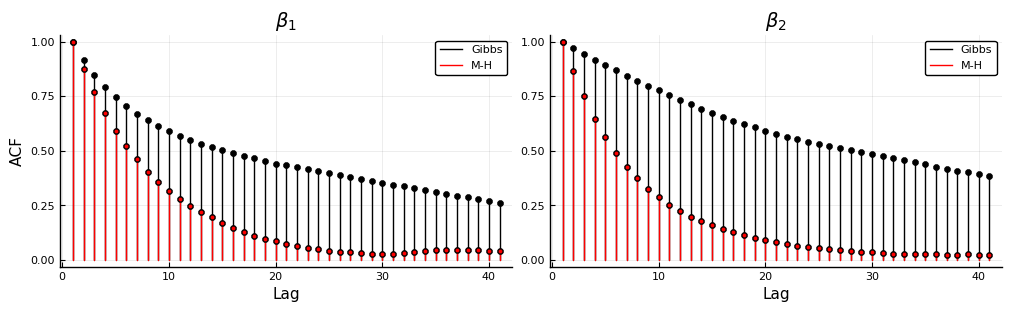

In [45]:
p1 = plot(autocor(GibbsChain[:,1]),line=:stem,marker=:o,color=:black,label="Gibbs")
p2 = plot!(autocor(C[:,1],(0:1:40)),line=:stem,marker=:o,color=:red,label="M-H",title=L"\beta_1",xlabel="Lag",ylabel="ACF")
p3 = plot(autocor(GibbsChain[:,2],(0:1:40)),line=:stem,marker=:o,color=:black,label="Gibbs")
p4 = plot!(autocor(C[:,2],(0:1:40)),line=:stem,marker=:o,color=:red,label="M-H",title=L"\beta_2",xlabel="Lag")
p6 = plot(p2,p4, layout=2, size=(1000,300))

savefig(p6,"./images/Ex6_6.png")